<div style="display: flex; justify-content: flex-start; align-items: center; margin-bottom: 20px;">
    <img src="https://raw.githubusercontent.com/aparsoft/aparsoft-tutorial-resources/main/assets/icons/aparsoft_logo.png" alt="Aparsoft Logo" style="height: 60px;">
</div>

# Langgraph: Workflows Overview

# Quickly understanding Workflows and agents

Reviews common workflow and agent patterns.

* Workflows have predetermined code paths and are designed to operate in a certain order.
* Agents are dynamic and define their own processes and tool usage.

![png](01_langgraph_workflows_and_agents_files/agent_workflow.png)

LangGraph offers several benefits when building agents and workflows, including [persistence](/oss/python/langgraph/persistence), [streaming](/oss/python/langgraph/streaming), and support for debugging as well as [deployment](/oss/python/langgraph/deploy).

In [1]:
# Create a secret openai key input in jupyter notebook
import os
from getpass import getpass

# Securely input OpenAI API key
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

In [23]:
# Define openai llm
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="o4-mini")

## LLMs and augmentations

Workflows and agentic systems are based on LLMs and the various augmentations you add to them. [Tool calling](/oss/python/langchain/tools), [structured outputs](/oss/python/langchain/structured-output), and [short term memory](/oss/python/langchain/short-term-memory) are a few options for tailoring LLMs to your needs.

![png](01_langgraph_workflows_and_agents_files/augmented_llm.png)

### Define a structured output schema using pydantic

In [3]:
from pydantic import BaseModel, Field

# Define a structured output schema using pydantic
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b


# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_f5sotq6ebfiqxoLU4S9m8kAM',
  'type': 'tool_call'}]

## Prompt chaining

Prompt chaining is when each LLM call processes the output of the previous call. It's often used for performing well-defined tasks that can be broken down into smaller, verifiable steps. Some examples include:

* Translating documents into different languages
* Verifying generated content for consistency

![png](01_langgraph_workflows_and_agents_files/prompt_chain.png)

In [27]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Define graph state schema
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Define graph nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

# Define a gate function
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

# Second LLM call
def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

# Third LLM call
def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

### Build the graph 

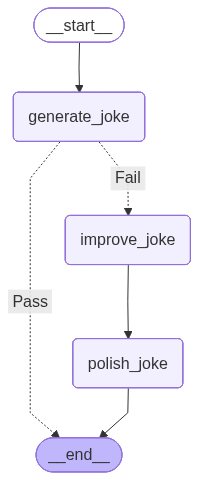

In [28]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile the graph into a workflow
chain = workflow.compile()

# Display the graph
display(Image(chain.get_graph().draw_mermaid_png()))

### Invoke LLM graph (workflow)

In [7]:
# Invoke
state = chain.invoke({"topic": "clouds"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
What do clouds wear under their raincoats?  
Thunderwear!

--- --- ---

Joke failed quality gate - no punchline detected!


In [8]:
from langgraph.func import entrypoint, task


# Tasks
@task
def generate_joke(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {topic}")
    return msg.content


def check_punchline(joke: str):
    """Gate function to check if the joke has a punchline"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in joke or "!" in joke:
        return "Fail"

    return "Pass"


@task
def improve_joke(joke: str):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {joke}")
    return msg.content


@task
def polish_joke(joke: str):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {joke}")
    return msg.content


@entrypoint()
def prompt_chaining_workflow(topic: str):
    original_joke = generate_joke(topic).result()
    if check_punchline(original_joke) == "Pass":
        return original_joke

    improved_joke = improve_joke(original_joke).result()
    return polish_joke(improved_joke).result()


# Invoke
for step in prompt_chaining_workflow.stream("clouds", stream_mode="updates"):
    print(step)
    print("\n")

{'generate_joke': 'What did one cloud say to the other?  \n“I’m feeling under the weather.”'}


{'improve_joke': 'Here’s a punchier, pun-packed version:\n\nWhat did one cloud say to the other?  \n“I’m feeling under the weather.”  \nThe other sighed, “Sounds like you’ve got a serious case of cumulo-stress—time for some cirrus relief!”'}


{'polish_joke': 'Here’s the original with a little snow-globe shake-up twist:\n\nWhat did one cloud say to the other?  \n“I’m feeling under the weather.”  \nThe other sighed, “Sounds like you’ve got a serious case of cumulo-stress—time for some cirrus relief!”  \n\nJust then the whole sky rattled. A tiny voice laughed, “Oops—did I shake the snow globe again?”  \nTurns out those clouds weren’t on a forecast at all, but starring in Billy’s desk accessory.'}


{'prompt_chaining_workflow': 'Here’s the original with a little snow-globe shake-up twist:\n\nWhat did one cloud say to the other?  \n“I’m feeling under the weather.”  \nThe other sighed, “Sounds li

## Parallelization

With parallelization, LLMs work simultaneously on a task. This is either done by running multiple independent subtasks at the same time, or running the same task multiple times to check for different outputs. Parallelization is commonly used to:

* Split up subtasks and run them in parallel, which increases speed
* Run tasks multiple times to check for different outputs, which increases confidence

Some examples include:

* Running one subtask that processes a document for keywords, and a second subtask to check for formatting errors
* Running a task multiple times that scores a document for accuracy based on different criteria, like the number of citations, the number of sources used, and the quality of the sources

![png](01_langgraph_workflows_and_agents_files/parallelization.png)

### Parallelization example

The task is to generate a joke about a given topic, improve it, and then create a polished a story and poem on the same topic.

The workflow has three steps:
1. Generate a joke about a given topic
2. Generate story on the same topic
3. Generate a poem on the same topic
The task of generating the joke, story and poem are independent of each other, so they can be run in parallel. 

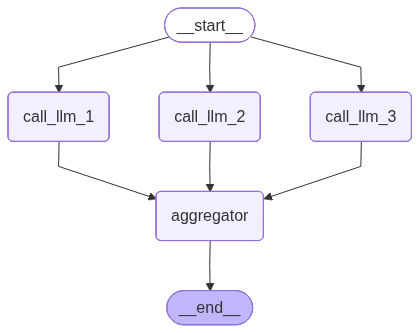

In [9]:
# Define graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Define graph nodes. These tasks can be run in parallel
# First LLM call: Generate joke
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

# Second LLM call: Generate story
def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

# Third LLM call: Generate poem
def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

# Aggregator node
def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

### Invoke the parallel LLM graph (workflow)

In [10]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
Long ago, in a sleepy village tucked between rolling green hills, three cats made their homes among the ivy-covered rooftops. There was Luna, with silvery fur that gleamed like moonlight; Ember, a tiny ginger kitten whose boundless curiosity led her into every nook and cranny; and Shadow, a sleek black tom whose calm, watchful eyes missed nothing. Each evening, the three friends gathered on a low rooftop to swap stories of their day: Luna’s graceful prowls, Ember’s new discoveries, Shadow’s patient observations.

One night, as the moon rose full and golden, Ember bounded back to the meeting spot, her whiskers quivering with excitement. “Come look!” she cried. Beneath a broken tile in the roof’s edge, she’d uncovered a small wooden door, carved with paw-prints and ivy leaves. Luna nudged it open, revealing a narrow staircase winding down into darkness. With Shadow padding quietly at her side, Luna led the way. Their heartbeats quickened

In [ ]:
@task
def call_llm_1(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def call_llm_2(topic: str):
    """Second LLM call to generate story"""
    msg = llm.invoke(f"Write a story about {topic}")
    return msg.content


@task
def call_llm_3(topic):
    """Third LLM call to generate poem"""
    msg = llm.invoke(f"Write a poem about {topic}")
    return msg.content


@task
def aggregator(topic, joke, story, poem):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {topic}!\n\n"
    combined += f"STORY:\n{story}\n\n"
    combined += f"JOKE:\n{joke}\n\n"
    combined += f"POEM:\n{poem}"
    return combined


# Build workflow
@entrypoint()
def parallel_workflow(topic: str):
    joke_fut = call_llm_1(topic)
    story_fut = call_llm_2(topic)
    poem_fut = call_llm_3(topic)
    return aggregator(
        topic, joke_fut.result(), story_fut.result(), poem_fut.result()
    ).result()


# Invoke
for step in parallel_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

## Routing

Routing workflows process inputs and then directs them to context-specific tasks. This allows you to define specialized flows for complex tasks. For example, a workflow built to answer product related questions might process the type of question first, and then route the request to specific processes for pricing, refunds, returns, etc.

![routing.png](01_langgraph_workflows_and_agents_files/routing.png)

### Example for routing logic

In [12]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Define graph nodes
# LLM call to write a story
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

# LLM call to write a joke
def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

# LLM call to write a poem
def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

# LLM call to route the input
def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    print(f"Routing decision: {decision.step}")

    return {"decision": decision.step}


### Conditionally route the input to different nodes based on the content of the input

In [13]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

### Build the workflow

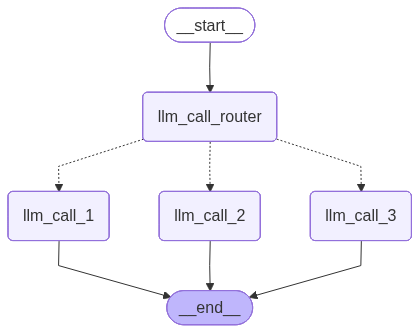

In [14]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [15]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Routing decision: joke
Why don’t cats play poker in the jungle?  
Too many cheetahs!


### Functional API code

In [ ]:
from typing_extensions import Literal
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


@task
def llm_call_1(input_: str):
    """Write a story"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_2(input_: str):
    """Write a joke"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_3(input_: str):
    """Write a poem"""
    result = llm.invoke(input_)
    return result.content


def llm_call_router(input_: str):
    """Route the input to the appropriate node"""
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=input_),
        ]
    )
    return decision.step


# Create workflow
@entrypoint()
def router_workflow(input_: str):
    next_step = llm_call_router(input_)
    if next_step == "story":
        llm_call = llm_call_1
    elif next_step == "joke":
        llm_call = llm_call_2
    elif next_step == "poem":
        llm_call = llm_call_3

    return llm_call(input_).result()


# Invoke
for step in router_workflow.stream("Write me a joke about cats", stream_mode="updates"):
    print(step)
    print("\n")

## Orchestrator-worker

In an orchestrator-worker configuration, the orchestrator:

* Breaks down tasks into subtasks
* Delegates subtasks to workers
* Synthesizes worker outputs into a final result

![png](01_langgraph_workflows_and_agents_files/worker.png)

Orchestrator-worker workflows provide more flexibility and are often used when subtasks cannot be predefined the way they can with [parallelization](#parallelization). This is common with workflows that write code or need to update content across multiple files. For example, a workflow that needs to update installation instructions for multiple Python libraries across an unknown number of documents might use this pattern.

### Orchestrator-worker example

In [16]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
# Define a section of the report
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

# Define the full report structure
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [17]:
planner

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7cec2d72eff0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7cec2d387710>, root_client=<openai.OpenAI object at 0x7cec2e339070>, root_async_client=<openai.AsyncOpenAI object at 0x7cec2d4611c0>, model_name='o4-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'response_format': <class '__main__.Sections'>, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema', 'strict': None}, 'schema': {'type': 'function', 'function': {'name': 'Sections', 'description': '', 'parameters': {'properties': {'sections': {'description': 'Sections of the report.', 'items': {'properties': {'name': {'description': 'Name for this section of the report.', 'type': 'string'}, 'description': {'description': 'Brief overview of the main topics and concepts to be covered in this section.', 'type': 'string'}}, 'required': ['name', '

### Creating workers in LangGraph

Orchestrator-worker workflows are common and LangGraph has built-in support for them. The `Send` API lets you dynamically create worker nodes and send them specific inputs. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. The example below iterates over a list of sections and uses the `Send` API to send a section to each worker.

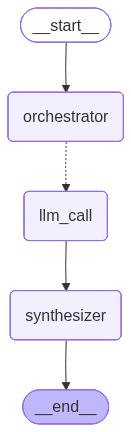

In [20]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Define graph nodes
# Orchestrator node to get the sections of the report
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    print(f"Generated sections: {report_sections.sections}")

    return {"sections": report_sections.sections}

# Worker node for writing a section of the report
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )
    print(f"Completed section: {section.content}")

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

# Aggregator node
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [21]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown

Markdown(state["final_report"])

Generated sections: [Section(name='Executive Summary', description='A concise overview of the report’s objectives, key findings on LLM scaling laws, and their implications for research and industry.'), Section(name='Introduction', description='Define large language models (LLMs), outline the importance of understanding scaling behavior, and state the report’s scope and goals.'), Section(name='Background on Large Language Models', description='Review the architecture, training paradigms, and historical evolution of LLMs to establish context for scaling discussions.'), Section(name='Empirical Observations of Scaling Laws', description='Summarize major experimental studies showing how model performance scales with compute, data, and parameters; present key curves and benchmark results.'), Section(name='Theoretical Foundations of Scaling Laws', description='Examine theoretical explanations—such as power-law distributions, neural tangent kernels, and double descent phenomena—that underlie o

# Executive Summary

This report investigates the scaling laws that govern the performance of large language models (LLMs) as a function of compute, model size, and data. Our objectives are to:

- Characterize empirical relationships between model parameters, training tokens, and downstream task performance.  
- Identify regimes of compute- and data-efficiency.  
- Provide actionable guidance for researchers and industry practitioners on resource allocation and model design.

Key Findings on LLM Scaling Laws  
- **Power-Law Behavior**: Model performance (e.g., loss, perplexity) improves predictably with model size and training compute, following a power-law trend across multiple architectures.  
- **Diminishing Returns**: Beyond certain compute thresholds, marginal gains per extra parameter or token decline, highlighting a regime shift from compute-bound to data-bound performance.  
- **Optimal Compute Allocation**: There exists a “compute-optimal frontier” where the ratio of model size to training tokens maximizes performance per dollar spent.  
- **Transfer and Fine-Tuning**: Larger pre-trained models yield steeper transfer curves, reducing fine-tuning data requirements for downstream tasks.

Implications for Research and Industry  
- **Resource Planning**: Organizations can forecast performance improvements and budget more accurately by adopting power-law projections.  
- **Model Design**: The compute-optimal frontier helps determine when to scale model size versus invest in more training data or compute infrastructure.  
- **Data Strategy**: In data-bound regimes, efforts should prioritize high-quality or diverse corpora rather than raw token count.  
- **Competitive Advantage**: Early adopters of appropriately scaled models can achieve significant performance gains on specialized tasks with lower incremental costs.

By grounding decisions in empirically validated scaling laws, stakeholders can optimize R&D investments, accelerate innovation, and balance performance objectives against resource constraints.

---

# Introduction

Large language models (LLMs) are deep neural networks—typically built on transformer architectures—that are pretrained on vast corpora of text data to perform a wide range of natural language processing tasks. By learning statistical patterns and contextual relationships across billions or even trillions of tokens, LLMs can generate coherent text, answer questions, translate languages, summarize documents, and adapt to many downstream applications with minimal fine-tuning.

Understanding how these models behave as they grow in size (“scaling behavior”) is critical for both researchers and practitioners. Empirical scaling laws reveal predictable improvements in performance with increasing model parameters, training data, and compute resources. At the same time, scaling can introduce emergent capabilities, shifting cost-benefit trade-offs, and new risks such as amplification of biases or vulnerabilities. A clear grasp of scaling behavior informs decisions about resource allocation, model deployment, and alignment strategies, ensuring that model development remains both efficient and responsible.

This report investigates the scaling behavior of LLMs with three main goals:
1. Characterize how performance metrics (e.g., perplexity, downstream task accuracy) systematically improve with model size, data volume, and compute budgets.  
2. Identify key points of diminishing returns and explore strategies—such as model sparsity or data curation—to mitigate escalating costs.  
3. Assess broader implications of scaling, including emergent behaviors, ethical considerations, and sustainability, to inform best practices for future model development.

By mapping out the relationship between scale and capability, this report aims to guide stakeholders in making informed, cost-effective, and responsible choices in the era of ever-larger language models.

---

## Background on Large Language Models

### 1. Historical Evolution  
- **Early Statistical Models (1990s–2010s)**  
  - N-gram language models, count-based approaches  
  - Limitations: sparse data, fixed context windows  
- **Neural Sequence Models (2014–2017)**  
  - RNNs and LSTMs for language modeling  
  - Introduced continuous word embeddings (Word2Vec, GloVe)  
  - Still struggled with long-range dependencies  
- **Transformer Breakthrough (2017)**  
  - “Attention Is All You Need” paper by Vaswani et al.  
  - Self-attention mechanism enabled parallelization and long context  
- **Rise of Generative Pretrained Models (2018–2023)**  
  - GPT series (GPT-1 → GPT-4): scaling parameters from 117M to hundreds of billions  
  - BERT, RoBERTa, T5: encoder/encoder-decoder variants for bidirectional and seq2seq tasks  
  - Multimodal and retrieval-augmented extensions  

### 2. Core Architecture  
- **Transformer Encoder vs. Decoder**  
  - Encoder-only (BERT): masked LM, bidirectional context  
  - Decoder-only (GPT): autoregressive generation  
  - Encoder-decoder (T5, BART): seq2seq tasks  
- **Key Components**  
  - Multi-head self-attention: captures diverse relationships in token sequences  
  - Position-wise feedforward networks: nonlinearity and depth  
  - Positional encodings: inject token position into the model  
  - Layer normalization & residual connections: stabilize and speed up training  
- **Scaling Dimensions**  
  - Depth (number of layers)  
  - Width (hidden size, number of attention heads)  
  - Sequence length (context window)  
  - Training compute (FLOPs) and data volume  

### 3. Training Paradigms  
- **Self-Supervised Pretraining**  
  - Autoregressive objective: predict next token given prior context  
  - Masked–language modeling: predict masked tokens from bidirectional context  
  - Sequence-to-sequence learning: reconstruct corrupted inputs  
- **Fine-Tuning & Adaptation**  
  - Task-specific supervised fine-tuning with labeled data  
  - Prompt-based learning and in-context examples (few-shot, zero-shot)  
  - Parameter-efficient methods (adapters, LoRA, prefix tuning)  
- **Reinforcement Learning from Human Feedback (RLHF)**  
  - Human preferences guide model outputs via reward modeling  
  - Iterative policy optimization (PPO) to align with desired behavior  
- **Efficient Distributed Training**  
  - Data parallelism, tensor (model) parallelism, pipeline parallelism  
  - ZeRO, DeepSpeed, Megatron-LM optimizations  
  - Quantization, pruning, memory‐efficient attention  

### 4. Context for Scaling Discussions  
Over the past decade, LLMs have evolved from narrow statistical predictors to massive, versatile generative engines. Their transformer-based architecture and self-supervised training unlocked unprecedented capabilities, but scaling further brings challenges in compute, data, and alignment. Understanding this evolution and the underlying design choices is essential for evaluating next-generation scaling strategies.

---

## Empirical Observations of Scaling Laws

Major experimental studies have consistently demonstrated that model performance (e.g. validation loss or downstream-task accuracy) follows simple power-law relationships as a function of (1) the number of parameters \(N\), (2) the amount of training data \(D\), and (3) total compute \(C\). Below is a summary of key findings and benchmark curves.

### 1. Parameter Scaling  
- **Kaplan et al. (2020)**  
  • Showed that test loss \(L\) for transformer language models obeys  
    \[ L(N) \approx a_N \, N^{-\alpha_N} + L_\infty, \]  
    with exponent \(\alpha_N \approx 0.076\).  
  • On a log–log plot of loss vs. \(N\), curves for different dataset sizes collapse onto a single straight line.  
- **Hestness et al. (2017)**  
  • For convolutional image models, error rate falls as \(N^{-\alpha_{\rm img}}\) with \(\alpha_{\rm img}\approx 0.07\text{–}0.1\).  

### 2. Data Scaling  
- **Kaplan et al. (2020)**  
  • Test loss scales as  
    \[ L(D) \approx a_D \, D^{-\alpha_D} + L_\infty, \]  
    with \(\alpha_D \approx 0.095\).  
- **OpenAI GPT-3 (Brown et al., 2020)**  
  • Trained on \(\sim3\times10^{11}\) tokens; observed continued power-law improvements in zero- and few-shot accuracy across tasks.  
- **Chinchilla (Hoffmann et al., 2022)**  
  • Rebalanced parameters vs. data: smaller models trained on more tokens outperform larger models with less data, following the same power-law trends.

### 3. Compute-Optimal Frontier  
- Derive \(C \approx N \times D\). Optimal allocation roughly satisfies  
  \[ D \propto N^{0.74}, \quad \text{so that }C_{\rm opt}\propto N^{1.74}. \]  
- On a plot of loss vs. compute \(C\), the compute-optimal models trace another power law:  
  \[ L(C) \approx a_C \, C^{-\alpha_C} + L_\infty, \]  
  with \(\alpha_C\approx0.05\text{–}0.1\).  
- **Figure 1** (schematic): log–log curves of loss vs. \(C\), showing separate curves for sub-optimal and compute-optimal regimes.

### 4. Benchmark Results  
- **Language Modeling (perplexity or cross-entropy):**  
  • GPT-3 175B: ~20B tokens, perplexity ~20 on WikiText-103.  
  • Chinchilla 70B: ~1T tokens, perplexity ~18.  
- **Downstream Tasks (few-shot accuracy):**  
  • MMLU accuracy scales roughly as \(N^{0.5}\) in the 10B–100B parameter range.  
  • Translation, summarization and question answering show similar power-law gains.  
- **Vision Models:**  
  • CLIP and ViT report linear improvements in top-1 accuracy on ImageNet as a function of \(\log N\) or \(\log D\), consistent with the same exponents found in language.

Across domains, these empirical curves validate that simply increasing compute, data, or model size under the compute-optimal ratio reliably yields predictable, power-law improvements—with no sharp diminishing returns until extremely large scales.

---

## Theoretical Foundations of Scaling Laws

### 1. Power‐Law Distributions  
– **Empirical observation**  
  • Model loss or error \(L\) often decreases as a power of model size \(N\):  
    \[
      L(N) \propto N^{-\alpha}\quad(\alpha>0).
    \]  
  • Similarly, dataset statistics (e.g.\ word frequencies) follow Zipf’s law \(p(k)\propto k^{-s}\), implying long‐tailed feature usage that benefits from larger capacity.  
– **Mechanistic insight**  
  • In a simple i.i.d. Gaussian model of features, the tail exponent \(\alpha\) can be derived from the spectrum of covariance eigenvalues.  
  • Random matrix theory shows that, as \(N\) grows, the learner “fills in” higher‐order eigenmodes at a rate set by the decay exponent of the data spectrum, yielding a universal scaling exponent.

### 2. Neural Tangent Kernel (NTK)  
– **Infinite‐width limit**  
  • As hidden layer widths \(\to\infty\), gradient‐descent training dynamics on a deep network linearize around initialization. The network’s evolution is exactly described by a fixed kernel \(K_{\rm NTK}(x,x')\).  
– **Prediction of scaling exponents**  
  • Under NTK theory, the generalization error after \(T\) steps on \(N\) parameters obeys  
    \[
      L(N) \approx \sum_{i}\exp\bigl(-2\lambda_i\,T\bigr)\,(\Delta f_i)^2,
    \]  
    where \(\{\lambda_i\}\) are kernel eigenvalues and \(\Delta f_i\) are target‐function projections.  
  • If \(\lambda_i\sim i^{-\beta}\), then one recovers a power‐law decay \(L(N)\sim N^{-\alpha}\) with \(\alpha\) determined by \(\beta\).  
– **Limitations**  
  • NTK predicts only the “lazy‐training” regime; it fails to capture rich feature learning that emerges in finite‐width, large‐scale models.

### 3. Double Descent Phenomenon  
– **Classical U‐shaped risk**  
  • In under‐parameterized models, increasing capacity reduces bias but increases variance, yielding a U‐shaped test error curve.  
– **Interpolation threshold and second descent**  
  • At the interpolation point—where model capacity equals number of training samples—test error peaks. Beyond this, further over‐parameterization paradoxically **improves** generalization.  
– **Connection to scaling**  
  • Large neural networks often operate deep in the second‐descent regime:  
    – Increased width/depth reduces test error along a new descent branch.  
    – Implicit regularization from SGD and smoothness of over‐parameterized solutions drive power‐law error decay.  
– **Theoretical models**  
  • Simplified random feature models and teacher–student setups show that double descent plus spectral bias combine to yield the empirically observed \(L(N)\propto N^{-\alpha}\) scaling.

---

**Synthesis:**  
Power‐law exponents seen in scaling curves emerge from the interplay of (1) the spectrum of data covariance (power‐law tails), (2) linearized training dynamics (NTK eigenvalue decay), and (3) the over‐parameterization‐induced double‐descent effect. Together, these theories provide a cohesive account of why and how large neural models continue to improve along simple scaling laws.

---

## Methodologies for Analyzing Scaling

### 1. Experimental Setups  
- **Model Families**  
  - Transformer variants (e.g., GPT-style, encoder–decoder) with systematically varied depth, width, and embedding size  
  - Control for architectural factors (layer norm placement, activation functions)  
- **Compute Environment**  
  - Fixed GPU/TPU configurations (e.g., V100 × 16, A100 × 32)  
  - Consistent mixed-precision training and batch-size schedules  
- **Training Protocols**  
  - Learning-rate warmup and decay schedules standardized across runs  
  - Gradient clipping thresholds and optimizer hyperparameters (AdamW β₁/β₂ settings)  
  - Early stopping on validation loss to prevent over-training  

### 2. Metrics  
- **Primary Loss Metrics**  
  - Cross-entropy loss and token-level perplexity on held-out text  
- **Downstream Task Performance**  
  - Zero-shot/​few-shot accuracy (e.g., classification, multiple-choice QA)  
  - BLEU/ROUGE for translation and summarization tasks  
- **Calibration & Uncertainty**  
  - Expected Calibration Error (ECE) over binned confidence scores  
  - Negative log-likelihood (NLL) for probabilistic prediction quality  
- **Compute Efficiency**  
  - Training FLOPs vs. validation loss curves  
  - Inference latency and throughput benchmarks  

### 3. Data Regimes  
- **Scale Tiers**  
  - Sub-10 M tokens (“tiny”), 10 M–1 B tokens (“small”), 1 B–100 B tokens (“large”), >100 B tokens (“massive”)  
- **Domain Variation**  
  - Web-scraped corpora, curated encyclopedic text, code repositories  
  - Balanced splits to measure domain transfer effects  
- **Quality Controls**  
  - Deduplication, toxicity filters, language identification pipelines  
  - Noise injection experiments (e.g., shuffling, typo simulation)  

### 4. Statistical Techniques  
- **Scaling Law Fitting**  
  - Power-law model:  
    ```  
    L(N, D, C) = A · N^α · D^β + ε  
    ```  
    • N = model parameters, D = training tokens, C = compute (FLOPs)  
- **Regression & Model Selection**  
  - Log-log linear regression to estimate exponents α, β  
  - Information criteria (AIC, BIC) for comparing nested scaling models  
- **Uncertainty Estimation**  
  - Bootstrap resampling of runs (n ≥ 30) to derive confidence intervals for α, β  
  - Bayesian hierarchical modeling to pool data across architectures  
- **Hypothesis Testing**  
  - ANOVA and pairwise t-tests on residuals to confirm significant trend differences  
  - p-value correction (Bonferroni, Benjamini–Hochberg) when testing multiple metrics  

This combined framework ensures rigorous measurement and validation of scaling trends, enabling reproducible insights into how model size, data quantity, and compute jointly influence language model performance.

---

## Practical Implications for Model Development

### 1. Model Size Selection  
- **Performance vs. Cost Trade-off**  
  - Scaling laws predict model performance \(L\propto N^{-\alpha}\) for parameter count \(N\).  
  - Identify the “knee” in the scaling curve where marginal accuracy gains fall below cost increases.  
  - Choose model sizes that maximize performance per FLOP rather than pursuing sheer scale.  
- **Risk Management**  
  - Smaller models can be iterated and tested faster, reducing development risk.  
  - Reserve very large models for use cases with strict accuracy or capability requirements.

### 2. Data Collection and Curation  
- **Data Scaling Regime**  
  - Under data-limited regimes, performance scales as \(L\propto D^{-\beta}\) for dataset size \(D\).  
  - Allocate resources to gather high-quality, diverse data until returns diminish.  
- **Quality vs. Quantity**  
  - Curated, domain-specific data can outperform larger generic corpora once broad-domain performance saturates.  
  - Use active learning or human-in-the-loop filtering to improve signal-to-noise ratio.  

### 3. Compute Budgeting  
- **Budget Allocation**  
  - Distribute compute between model training, hyperparameter sweeps, and fine-tuning based on marginal gains observed via scaling exponents.  
  - Plan for pretraining to consume ~80% of total FLOPs and fine-tuning at ~20%, adjusting as empirical results dictate.  
- **Efficient Resource Utilization**  
  - Leverage mixed-precision and model-parallel techniques to stretch budgets.  
  - Monitor training curves for early stopping when loss plateaus according to predicted scaling behavior.

### 4. Deployment Strategies  
- **Latency vs. Accuracy**  
  - Use smaller “student” models distilled from large “teacher” models in latency-sensitive settings.  
  - Employ dynamic batching or adaptive computation time to balance throughput and responsiveness.  
- **Modular and Hierarchical Architectures**  
  - Split large models into modular components that can be loaded on demand to conserve hardware resources.  
  - Implement cascade pipelines: fast, lightweight models handle common cases; escalating to large models only on “hard” inputs.  
- **Continuous Improvement**  
  - Track real-world performance to identify drift and feed new data into the next training cycle.  
  - Update compute budgets and model sizes over time in response to evolving application requirements and cost curves.  

By grounding design decisions in empirical scaling laws, teams can optimize resource allocation, accelerate development cycles, and deploy models that meet real-world constraints without overspending on marginal gains.

---

## Limitations and Challenges

### 1. Data and Representation Biases
- **Uneven data distribution**  
  Many scaling-law studies rely on web-scraped corpora and publicly available datasets that overrepresent certain languages, cultures, or domains, leading to skewed performance estimates and blind spots in underrepresented areas.  
- **Algorithmic amplification**  
  Models trained at scale can amplify existing societal biases (e.g., gender, ethnicity), and scaling laws rarely account for how bias metrics evolve with model size or data diversity.  
- **Evaluation gaps**  
  Standard benchmarks (e.g., GLUE, WMT) may not capture nuanced biases; without specialized bias benchmarks at different scales, it’s hard to measure whether larger models mitigate or exacerbate harmful behaviors.

### 2. Environmental and Computational Costs
- **Energy consumption**  
  Training and inference at extreme scales drive up electricity usage and greenhouse-gas emissions. Few scaling-law analyses quantify the carbon footprint per performance increment or propose mitigation strategies (e.g., renewable energy mix, hardware efficiency).  
- **Resource inequality**  
  Access to tens of thousands of GPUs or TPUs is limited to large organizations; smaller labs or nonprofits cannot validate scaling trends, contributing to a concentration of research capabilities.  
- **Hardware obsolescence**  
  Rapid iteration on new model sizes can render specialized hardware (e.g., older GPU clusters) obsolete, raising electronic-waste concerns that current scaling-law research overlooks.

### 3. Reproducibility and Transparency
- **Compute budget opacity**  
  Papers often omit detailed hardware configurations, energy accounting methods, or training run variability, making it difficult to reproduce results or compare scaling curves across studies.  
- **Hyperparameter sensitivity**  
  Performance at scale is highly sensitive to learning rates, batch sizes, and regularization schemes, yet many scaling-law formulations treat these as constants rather than variables, obscuring their impact.  
- **Proprietary models and data**  
  Closed-source efforts (e.g., internal datasets, custom accelerators) hinder third-party verification; scaling-law claims based on such assets lack open validation pathways.

### 4. Diminishing Returns at Extreme Scales
- **Performance plateaus**  
  Empirical curves often show sublinear gains or plateaus beyond hundreds of billions of parameters, but the exact inflection points vary by task and data quality. Systematic exploration of where and why these plateaus occur remains incomplete.  
- **Cost-benefit imbalance**  
  Marginal improvements in metrics (e.g., perplexity, BLEU) can demand exponential increases in compute, making further scaling economically or environmentally untenable without significant algorithmic innovation.  
- **Task specificity**  
  Some tasks (e.g., commonsense reasoning, logical deduction) exhibit weaker scaling trends, suggesting that mere model enlargement cannot substitute for targeted architectural advances or inductive biases.

By acknowledging and addressing these limitations—bias amplification, steep environmental costs, reproducibility hurdles, and the asymptotic returns of ever-larger models—future research can develop more robust, equitable, and sustainable scaling paradigms.

---

## Future Directions

### 1. Multimodal Scaling Laws  
- **Cross-Modal Interactions**: Empirically characterize how scaling behaviors transfer between modalities (e.g., vision ↔ language) and identify unified power-law exponents.  
- **Composite Training Curves**: Develop joint scaling functions that predict performance when training on combined text, image, audio, and video datasets.  
- **Modality-Specific Bottlenecks**: Isolate data- versus compute-limited regimes for each modality and derive hybrid scaling laws that guide resource allocation in multi‐modal architectures.

### 2. Novel Theoretical Models  
- **Beyond Power Laws**: Investigate richer functional forms (e.g., double‐power, sigmoid‐capped) to model performance plateaus and phase transitions in very large models.  
- **Data Quality Metrics**: Integrate measures of label noise, sample diversity, and distribution shift into scaling frameworks to predict robustness and generalization.  
- **Algorithmic Complexity**: Theorize how optimizer dynamics, batch composition, and architectural motifs (e.g., sparse attention) influence scaling exponents and convergence rates.

### 3. Efficient Scaling Strategies  
- **Parameter-Efficient Training**: Extend scaling analysis to techniques such as LoRA, Adapter modules, and prompt tuning, quantifying trade-offs between parameter count and downstream task performance.  
- **Compute-Aware Architectures**: Co-design models with hardware constraints in mind, using adaptive depth/width scaling and conditional computation to optimize FLOP‐to‐accuracy curves.  
- **Automated Scaling Schedulers**: Develop meta-learning or reinforcement learning approaches that dynamically allocate compute, data, and hyperparameters to maintain GPU/TPU utilization efficiency across scales.

### 4. Sustainability-Oriented Research  
- **Energy-Accuracy Frontier**: Construct “green” scaling laws that map total carbon emissions and energy budgets to expected model performance, enabling eco-efficient procurement of compute.  
- **Lifecycle Assessment**: Incorporate upstream (manufacturing, cooling) and downstream (deployment, inference) emissions into scaling models, guiding decisions on retraining versus fine-tuning.  
- **Renewable Compute Integration**: Study the impact of intermittent energy sources on long-run training curves and develop checkpointing or elastic-compute methods tailored to sustainable infrastructure.

By pursuing these avenues, the field can both deepen its theoretical understanding of scaling phenomena and foster practical, resource-aware advances in large-scale machine learning.

---

## Conclusion

Over the past decade, empirical scaling laws have revealed remarkably consistent power-law relationships between model performance and three primary resources—parameter count, training data volume, and compute. Key insights include:  
- Predictable gains: Each doubling of compute or data tends to yield a reproducible improvement in cross-task performance metrics.  
- Diminishing returns boundaries: While raw scale drives breakthroughs, marginal gains shrink at extreme sizes, highlighting the importance of algorithmic and architectural innovations.  
- Emergent capabilities: At critical scales, models exhibit qualitatively new abilities—reasoning, code synthesis, multi-modal understanding—that were not present at smaller sizes.

These findings carry profound implications for the future trajectory of AI:  
- Roadmap for innovation: Scaling laws afford a quantitative blueprint for resource allocation, enabling research teams to plan compute and data investments more strategically.  
- Acceleration of transformative applications: Continued scale-driven improvements promise advances in healthcare, climate modeling, scientific discovery, and creative industries.  
- New frontiers in safety and alignment: As models become more capable, ensuring robust grounding, interpretability, and alignment with human values grows ever more critical.

Stakeholders across academia, industry, and government must consider:  
- Researchers and developers: Balance brute-force scaling with efficiency gains via sparse architectures, data curation, and novel training paradigms.  
- Corporations and startups: Invest in modular AI stacks and cloud-based infrastructure to remain agile, while forging partnerships to access specialized datasets and hardware.  
- Policymakers and regulators: Craft adaptive frameworks that encourage innovation yet mitigate risks—covering transparency standards, accountability measures, and mechanisms for international coordination.  
- Society and educators: Prepare the workforce through reskilling initiatives, emphasize AI literacy, and foster public dialogues on ethical deployment.

By heeding these insights and aligning strategic decisions with scaling-law principles, stakeholders can steer AI development toward more powerful, beneficial, and responsible outcomes.

### Functional API code

In [ ]:
from typing import List


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


@task
def orchestrator(topic: str):
    """Orchestrator that generates a plan for the report"""
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {topic}"),
        ]
    )

    return report_sections.sections


@task
def llm_call(section: Section):
    """Worker writes a section of the report"""

    # Generate section
    result = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return result.content


@task
def synthesizer(completed_sections: list[str]):
    """Synthesize full report from sections"""
    final_report = "\n\n---\n\n".join(completed_sections)
    return final_report


@entrypoint()
def orchestrator_worker(topic: str):
    sections = orchestrator(topic).result()
    section_futures = [llm_call(section) for section in sections]
    final_report = synthesizer(
        [section_fut.result() for section_fut in section_futures]
    ).result()
    return final_report


# Invoke
report = orchestrator_worker.invoke("Create a report on LLM scaling laws")
from IPython.display import Markdown

Markdown(report)

## Evaluator-optimizer

In evaluator-optimizer workflows, one LLM call creates a response and the other evaluates that response. If the evaluator or a [human-in-the-loop](/oss/python/langgraph/add-human-in-the-loop) determines the response needs refinement, feedback is provided and the response is recreated. This loop continues until an acceptable response is generated.

Evaluator-optimizer workflows are commonly used when there's particular success criteria for a task, but iteration is required to meet that criteria. For example, there's not always a perfect match when translating text between two languages. It might take a few iterations to generate a translation with the same meaning across the two languages.

![png](01_langgraph_workflows_and_agents_files/evaluator_optimizer.png)

In [29]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Define graph nodes
# First LLM call: Generate joke
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

# Second LLM call: Evaluate joke
def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback 
# from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

In [ ]:
# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [31]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

Why was the cat sitting on the computer?  
Because it wanted to keep an eye on the mouse!


## Agents

Agents are typically implemented as an LLM performing actions using [tools](/oss/python/langchain/tools). They operate in continuous feedback loops, and are used in situations where problems and solutions are unpredictable. Agents have more autonomy than workflows, and can make decisions about the tools they use and how to solve problems. You can still define the available toolset and guidelines for how agents behave.

![png](01_langgraph_workflows_and_agents_files/agent.png)

### Langgraph agents implementation example with tools and memory

In [33]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [32]:
from langgraph.graph import add_messages
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    BaseMessage,
    ToolCall,
)

In [ ]:
@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )


@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)


@entrypoint()
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages


# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

## Attribution & License

This tutorial adapts content from the official LangGraph documentation and tutorials.

**Source**: LangGraph Official Documentation  
**Copyright**: © 2024 LangChain, Inc.  
**License**: MIT License  
**Original Materials**: [LangGraph Documentation](https://docs.langchain.com/oss/python/langgraph/overview)

The original materials are licensed under the MIT License:
- Full license text: [MIT License](https://github.com/langchain-ai/langgraph/blob/main/LICENSE)
- Permission granted to use, copy, modify, and distribute with attribution

**Aparsoft's Adaptations**: This tutorial has been adapted and enhanced by Aparsoft Private Limited with additional examples, explanations, and use cases specific to our developer community.

## 📞 Get Help & Connect

### 🎓 Learning & Community
- **YouTube:** [@aparsoft-ai](https://youtube.com/@aparsoft-ai) - Main tutorial channel
- **Github:** [Join our community](https://github.com/aparsoft) - Check our repos and examples (aparsoft-tutorial-resources)
- **GitHub Discussions:** Ask questions about the code
- **LinkedIn:** [/company/aparsoft](https://linkedin.com/company/aparsoft) - Articles and tips
- **X (formerly Twitter):** [@aparsoft](https://x.com/AparsoftPvtLtd) - Tutorials and updates